# 4.5: 生成式张量网络机器学习及优化算法

**ResMPS** : 将张量网络 (MPS) 看作从多个向量到单个向量 (或张量) 的映射，实现分类等预测；

**生成式MPS** (generative MPS, 简称GMPS) : 由MPS给出样本的概率分布，实现生成任务。

> 核心是波恩概率诠释，见 [2.1](2-1.ipynb)

GMPS：将样本出现的概率定义为对该样本进行特征映射后所得量子态与MPS态$|\phi\rangle$内积的模方

将"0"（例如一个白色像素）映射为$|0\rangle$，将"1"（例如一个黑色像素）映射为$|1\rangle$，则样本"10101"被映射为直积态$|10101\rangle$。对于给定量子态$|\phi\rangle$，我们设其为矩阵乘积态，则样本"10101"在$|\phi\rangle$中出现的概率满足

$$p(\text{"10101"}) = \frac{|\langle10101|\phi\rangle|^2}{\langle\phi|\phi\rangle}$$

![gmps_example](./images/gmps_example.png)

> 量子概率性机器学习模型又被称为波恩机

## GMPS 训练

核心任务：为在保持其量子概率诠释的前提下优化局域张量，使得NLL函数极小

损失函数：负对数似然（negative logarithmic likelihood，简称NLL）；

在目标概率分布为等概率分布时，NLL与交叉熵（见第三章第3节）仅相差一个常数。

具体而言：计算矩阵乘积态对于某个数据集中所有样本的概率分布，并训练矩阵乘积态（即优化局域张量），使得各个样本在矩阵乘积态中出现的概率接近其在数据集中出现的概率。一般而言，各个样本在数据集出现的次数为1，因此，我们需要优化局域张量，使得矩阵乘积态给出的各个样本的概率相等。

> NLL函数定义：
> 
> $$f = -\frac{1}{M}\sum_{m=0}^{M-1}\ln\frac{|\langle\phi^{(m)}|\phi\rangle|^2}{(\phi|\phi)} = -\frac{1}{M}\sum_{m=0}^{M-1}[\ln|\langle\phi^{(m)}|\phi\rangle|^2-\ln(\phi|\phi)]$$

Reference:
* [Supervised Learning with Tensor Networks](https://papers.nips.cc/paper_files/paper/2016/hash/5314b9674c86e3f9d1ba25ef9bb32895-Abstract.html)

### 张量网络的梯度计算
TODO: Add Figure

例子：
![tensor_network_gradient_calculation_example](./images/tensor_network_gradient_calculation_example.png)

> * 梯度的第一项对应于 NLL 的第二项，梯度的第二项对应于 NLL 的第一项，因为合并了最前面的负号
> * 梯度第一项的形式需要中心正交形式，例子里的 MPS 的中心必须是在第 2 号局域张量

计算的时候可以从两端向正交中心迭代计算，好处是梯度计算公式的上下部分可以复用部分计算

## Code

In [1]:
# |default_exp algorithms.gmps
# |export
import torch
from tensor_network.mps.modules import MPS, MPSType
from einops import einsum
from tqdm.auto import tqdm
from typing import Tuple, List
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# |export
EPS = 1e-14


# prepare env vectors from left to right
def calc_left_to_right_step(
    current_tensor: torch.Tensor,
    current_env_vector_left: torch.Tensor,
    current_sample: torch.Tensor,
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Calculate one step from left to right of the sweep algorithm
    """
    next_env_vector_left = einsum(
        current_env_vector_left,
        current_sample,
        current_tensor,
        "batch left, batch physical, left physical right -> batch right",
    )
    current_norm_factor = next_env_vector_left.norm(dim=1, keepdim=True)
    return next_env_vector_left / (current_norm_factor + EPS), current_norm_factor.squeeze(-1)


def calc_right_to_left_step(
    current_tensor: torch.Tensor,
    current_env_vector_right: torch.Tensor,
    current_sample: torch.Tensor,
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Calculate one step from right to left of the sweep algorithm
    """
    next_env_vector_right = einsum(
        current_env_vector_right,
        current_sample,
        current_tensor,
        "batch right, batch physical, left physical right -> batch left",
    )
    current_norm_factor = next_env_vector_right.norm(dim=1, keepdim=True)
    return next_env_vector_right / (current_norm_factor + EPS), current_norm_factor.squeeze(-1)


def calc_nll(norm_factors: torch.Tensor) -> torch.Tensor:
    """
    Calculate the negative log likelihood from the norm factors in a batch
    """
    nll = -2 * torch.log(norm_factors.abs() + EPS).sum(dim=1)  # (batch)
    return nll


@torch.compile
def calc_gradient(
    env_left_vector: torch.Tensor,
    env_right_vector: torch.Tensor,
    current_sample: torch.Tensor,
    current_tensor: torch.Tensor,
    enable_tsgo: bool,
) -> torch.Tensor:
    """
    Calculate the gradient w.r.t. the current tensor
    """
    raw_grad = einsum(
        env_left_vector,
        current_sample,
        env_right_vector,
        "batch left, batch physical, batch right -> batch left physical right",
    )
    norm = einsum(
        current_tensor,
        raw_grad,
        "left physical right, batch left physical right -> batch",
    )
    norm += torch.sign(norm) * EPS  # add a small number to avoid division by zero
    grad_part = (raw_grad / norm.view(-1, 1, 1, 1)).mean(dim=0)
    grad = 2 * (current_tensor - grad_part)
    grad_shape = grad.shape
    assert grad_shape == current_tensor.shape
    if enable_tsgo:
        grad = grad.reshape(-1)
        current_tensor = current_tensor.reshape(-1)
        projection = torch.dot(grad, current_tensor) * current_tensor
        grad = grad - projection
        grad = grad.reshape(grad_shape)

    grad /= grad.norm()
    return grad


def eval_nll(
    *,
    samples: torch.Tensor,
    mps: MPS,
    device: torch.device,
) -> torch.Tensor:
    assert samples.ndim == 3  # (dataset_size, feature_num, feature_dim)
    assert mps.center is not None
    dataset_size, feature_num, _ = samples.shape
    assert feature_num == mps.length
    # set default device to device
    prev_device = torch.get_default_device()
    torch.set_default_device(device)
    mps_local_tensors = mps.local_tensors
    batch_size = dataset_size  # since we do the init NLL evaluation in one go
    env_vectors_left: List[torch.Tensor | None] = [None] * mps.length
    left_virtual_dim = mps_local_tensors[0].shape[0]
    env_vectors_left[0] = torch.ones(batch_size, left_virtual_dim)
    env_vectors_right: List[torch.Tensor | None] = [None] * mps.length
    right_virtual_dim = mps_local_tensors[-1].shape[-1]
    env_vectors_right[-1] = torch.ones(batch_size, right_virtual_dim)
    norm_factors = torch.ones(batch_size, feature_num)

    def samples_at(idx):
        return samples[:, idx, :]  # (batch, feature_dim)

    for idx in range(mps.center):
        next_env_vector_left, current_norm_factor = calc_left_to_right_step(
            mps_local_tensors[idx],
            env_vectors_left[idx],
            samples_at(idx),
        )
        # set the norm factor for current position to be the norm of the next env vector, since the next env vector is to be normalized
        norm_factors[:, idx] = current_norm_factor
        env_vectors_left[idx + 1] = next_env_vector_left

    # prepare env vectors from right to left
    for idx in range(mps.length - 1, mps.center, -1):
        next_env_vector_right, current_norm_factor = calc_right_to_left_step(
            mps_local_tensors[idx],
            env_vectors_right[idx],
            samples_at(idx),
        )
        norm_factors[:, idx] = current_norm_factor
        env_vectors_right[idx - 1] = next_env_vector_right

    # update the norm factor at the center
    norm_factors[:, mps.center] = einsum(
        mps_local_tensors[mps.center],
        env_vectors_left[mps.center],
        samples_at(mps.center),
        env_vectors_right[mps.center],
        "left physical right, batch left, batch physical, batch right -> batch",
    )

    nll = calc_nll(norm_factors).mean()
    # restore the default device
    torch.set_default_device(prev_device)
    return nll


def train_gmps(
    *,
    samples: torch.Tensor,
    batch_size: int,
    mps: MPS,
    sweep_times: int,
    lr: float,
    device: torch.device,
    enable_tsgo: bool,
) -> Tuple[torch.Tensor, MPS]:
    dataset_size = samples.shape[0]
    assert dataset_size % batch_size == 0
    assert mps.mps_type == MPSType.Open
    # prepare mps, normalize first to avoid numerical instability
    mps.center_orthogonalization_(0, mode="qr", normalize=True, check_nan=True)
    init_nll = eval_nll(samples=samples, mps=mps, device=device)
    print(f"Initially, nll = {init_nll}")

    # set default device to device
    prev_device = torch.get_default_device()
    torch.set_default_device(device)
    # prepare dataloader
    dataloader = DataLoader(TensorDataset(samples), batch_size=batch_size, shuffle=True)

    mps_local_tensors = mps._mps  # CAREFUL for inplace operation
    feature_num = mps.length
    left_virtual_dim = mps_local_tensors[0].shape[0]
    right_virtual_dim = mps_local_tensors[-1].shape[-1]

    nll_losses = [init_nll]

    progress_bar = tqdm(range(sweep_times))
    for i in progress_bar:
        epoch_nll_losses = []
        for batch_data in tqdm(dataloader, leave=False):
            batch_data = batch_data[0]
            batch_size = batch_data.shape[0]
            # prepare aux variables
            env_vectors_left: List[torch.Tensor | None] = [None] * mps.length
            env_vectors_left[0] = torch.ones(batch_size, left_virtual_dim)
            env_vectors_right: List[torch.Tensor | None] = [None] * mps.length
            env_vectors_right[-1] = torch.ones(batch_size, right_virtual_dim)
            norm_factors = torch.ones(batch_size, feature_num)

            def data_at(idx):
                return batch_data[:, idx, :]  # (batch, feature_dim)

            # prepare env vectors from right to left
            # leave out left-to-right because the center of mps always starts at 0
            for idx in range(mps.length - 1, mps.center, -1):
                next_env_vector_right, current_norm_factor = calc_right_to_left_step(
                    mps_local_tensors[idx],
                    env_vectors_right[idx],
                    data_at(idx),
                )
                norm_factors[:, idx] = current_norm_factor
                env_vectors_right[idx - 1] = next_env_vector_right

            # update the norm factor at the center
            norm_factors[:, mps.center] = einsum(
                mps_local_tensors[mps.center],
                env_vectors_left[mps.center],
                data_at(mps.center),
                env_vectors_right[mps.center],
                "left physical right, batch left, batch physical, batch right -> batch",
            )

            # gradient calculation and optimization, from left to right
            for idx in range(mps.length):
                assert idx == mps.center
                grad = calc_gradient(
                    env_vectors_left[idx],
                    env_vectors_right[idx],
                    data_at(idx),
                    mps_local_tensors[idx],
                    enable_tsgo,
                )
                # update the tensor with gradient, inplace operation, will change mps._mps
                mps_local_tensors[idx] -= lr * grad

                # prepare for the next iteration
                if idx < mps.length - 1:
                    # move the center to the right
                    # the local tensors (mps._mps) at idx and idx + 1 will be changed
                    mps.center_orthogonalization_(idx + 1, mode="qr", normalize=True)
                    # so we need to update aux variables, only env_vectors_left affected
                    new_next_env_vector_left, new_norm_factor = calc_left_to_right_step(
                        mps_local_tensors[idx],
                        env_vectors_left[idx],
                        data_at(idx),
                    )
                    env_vectors_left[idx + 1] = new_next_env_vector_left
                    norm_factors[:, idx] = new_norm_factor
                else:
                    # we need normalization here to make mps as a unit norm state so to preserve the probability interpretation
                    mps.center_normalize_()

            for idx in range(mps.length - 1, -1, -1):
                assert idx == mps.center
                grad = calc_gradient(
                    env_vectors_left[idx],
                    env_vectors_right[idx],
                    data_at(idx),
                    mps_local_tensors[idx],
                    enable_tsgo,
                )
                mps_local_tensors[idx] -= lr * grad
                # prepare for the next iteration
                if idx > 0:
                    # move the center to the left
                    # the local tensors (mps._mps) at idx and idx - 1 will be changed
                    mps.center_orthogonalization_(idx - 1, mode="qr", normalize=True)
                    # so we need to update aux variables, only env_vectors_right affected
                    new_next_env_vector_right, new_norm_factor = calc_right_to_left_step(
                        mps_local_tensors[idx],
                        env_vectors_right[idx],
                        data_at(idx),
                    )
                    env_vectors_right[idx - 1] = new_next_env_vector_right
                    norm_factors[:, idx] = new_norm_factor
                else:
                    # we need normalization here to make mps as a unit norm state so to preserve the probability interpretation
                    mps.center_normalize_()

            assert mps.center == 0
            # update the norm factor at the center
            norm_factors[:, mps.center] = einsum(
                mps_local_tensors[mps.center],
                env_vectors_left[mps.center],
                data_at(mps.center),
                env_vectors_right[mps.center],
                "left physical right, batch left, batch physical, batch right -> batch",
            )
            batch_nll_loss = calc_nll(norm_factors)
            epoch_nll_losses.append(batch_nll_loss)

        epoch_nll_loss = torch.cat(epoch_nll_losses).mean()
        nll_losses.append(epoch_nll_loss)
        progress_bar.set_description(f"Iter {i} NLL: {epoch_nll_loss:.4f}")

    # restore the default device
    torch.set_default_device(prev_device)
    return torch.stack(nll_losses), mps

In [3]:
from tensor_network.utils.data import get_fashion_mnist_datasets
import os
from torch.utils.data import DataLoader
from tensor_network.feature_mapping import cossin_feature_map

cwd = os.getcwd()
cache_path = os.path.join(cwd, "datasets")

In [4]:
train_set, test_set = get_fashion_mnist_datasets(cache_path)
t_loader = DataLoader(train_set, batch_size=len(train_set), shuffle=False)
train_data, train_labels = next(iter(t_loader))
t_loader = DataLoader(test_set, batch_size=len(test_set), shuffle=False)
test_data, test_labels = next(iter(t_loader))

In [5]:
# hyperparameters
device = torch.device("cpu")
lr = 1e-1
sweep_times = 10

feature_dim = 2  # since we use cossin feature map
feature_num = 28 * 28
virtual_dim = 64

train_class = 0

In [6]:
theta = 0.5  # theta is important to map the feature in range [0, 1]

train_data = train_data[train_labels == train_class]
train_data = train_data.reshape(train_data.shape[0], -1).to(device)
train_data = cossin_feature_map(train_data, theta=theta)
test_data = test_data[test_labels == train_class]
test_data = test_data.reshape(test_data.shape[0], -1).to(device)
test_data = cossin_feature_map(test_data, theta=theta)

In [7]:
mps = MPS(
    length=feature_num,
    physical_dim=feature_dim,
    virtual_dim=virtual_dim,
    mps_type=MPSType.Open,
    dtype=torch.float32,
    device=device,
    requires_grad=False,
)

In [8]:
losses, mps = train_gmps(
    samples=train_data,
    batch_size=train_data.shape[0],  # mega batch, can change to micro batch
    mps=mps,
    sweep_times=sweep_times,
    lr=lr,
    device=device,
    enable_tsgo=True,
)
# TODO: add autograd version and compare the performance

Initially, nll = 555.7450561523438


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
test_nll = eval_nll(samples=test_data, mps=mps, device=device)
print(f"Test NLL: {test_nll:.4f}")

Test NLL: 35.3675


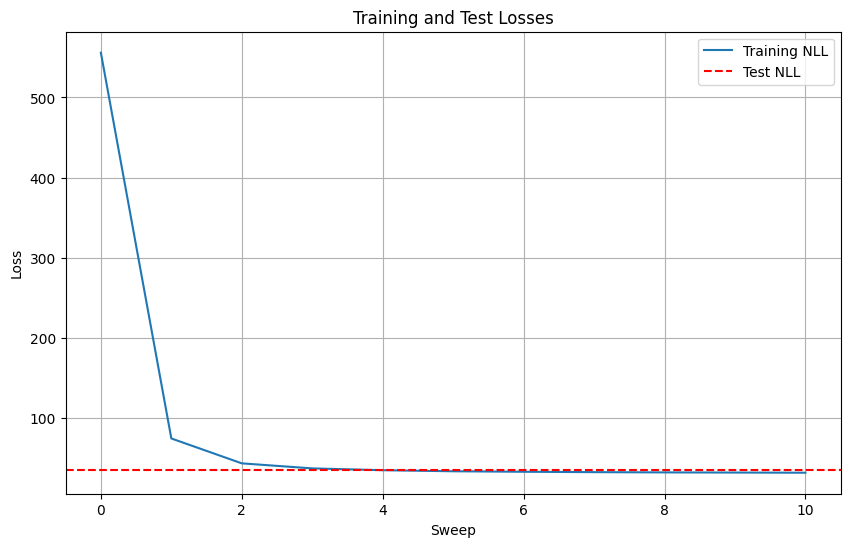

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(losses, label="Training NLL")
plt.axhline(y=test_nll, color="r", linestyle="--", label="Test NLL")
plt.xlabel("Sweep")
plt.ylabel("Loss")
plt.title("Training and Test Losses")
plt.legend()
plt.grid(True)
plt.show()